In [1]:
import sys
sys.path.append('..')

import dgl
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from KGCN import Model, loss_fn
from sklearn.metrics import roc_auc_score
from util import Group
import pickle

Using backend: pytorch


In [2]:
def process_graph(graph: dgl.heterograph):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ground_truth = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    user_repo = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue

        edges = graph.edges(etype=etype)

        ground_truth[edges[0], edges[1]] = 1
        user_repo[edges[0], edges[1]] = 1
    
    repos_per_user = torch.sum(user_repo, axis=1)

    return ground_truth, repos_per_user.numpy()

In [3]:
def process_edge_data(graph, edge_data):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ratings = np.zeros((number_of_users, number_of_repos))
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        edges = graph.edges(etype=etype)
        data = torch.squeeze(edge_data[etype]).numpy()
        ratings[edges[0], edges[1]] = np.maximum(ratings[edges[0], edges[1]], data)
    
    return ratings

In [4]:
def compute_auc(graph, pos_score, neg_score):
    auc_scores = []
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        pos_data = torch.squeeze(pos_score[etype])
        neg_data = torch.squeeze(neg_score[etype])
        
        scores = torch.cat([pos_data, neg_data]).numpy()
        labels = torch.cat(
            [torch.ones(pos_data.shape[0]), torch.zeros(neg_data.shape[0])]).numpy()

        auc_score = roc_auc_score(labels, scores)

        auc_scores.append(auc_score)
    
    return np.mean(auc_scores)

In [5]:
interaction_matrix = pickle.load(open('../data/interaction_matrix.p', 'rb'))
user_repos = np.sum(interaction_matrix, axis=1)
user_1_repo = np.where(user_repos==1)[0]

In [7]:
training_results = []

EPOCH = 100
TOP_K = 15
NEG_SAMPLE_SIZE = 5
USER_INPUT_SIZE = 150
REPO_INPUT_SIZE = 361
USER_REPO_OUTPUT_SIZE = 125
HIDDEN_OUTPUT_SIZE = 96
OUT_SIZE = 50

g, l = dgl.load_graphs('../data/sub_kowledge_graph.bin')
train_graph = g[0]
valid_graph = g[1]
test_graph = g[2]
train_pos_g = g[3]
train_neg_g = g[4]
valid_pos_g = g[5]
valid_neg_g = g[6]
test_pos_g = g[7]
test_neg_g = g[8]

model = Model(train_graph, USER_INPUT_SIZE, REPO_INPUT_SIZE, USER_REPO_OUTPUT_SIZE, HIDDEN_OUTPUT_SIZE, OUT_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

ground_truth_valid_data, repos_per_user_valid = process_graph(valid_graph)
ground_truth_test_data, repos_per_user_test = process_graph(test_graph)

for epoch in range(EPOCH):
    training_loops = 0
    total_loss = 0

    user_feat = train_graph.ndata['graph_data']['user']
    repo_feat = train_graph.ndata['graph_data']['repo']
    model.train()
    pos_score, neg_score = model(train_graph, train_pos_g, train_neg_g, user_feat, repo_feat)
    loss = loss_fn(pos_score, neg_score)

    total_loss += loss.item()
    training_loops += 1

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_avg_loss = total_loss / training_loops

    if epoch % 5 == 0:
        # valid top k recommendation
        model.eval()
        with torch.no_grad():
            # hit rate
            valid_mean_hit_rate = 0
            valid_group_hit_rate = {}
            hit_rates = np.zeros(valid_graph.num_nodes('user'))
            hit_rate_groups = Group()

            # MRR
            valid_mrr = 0
            valid_group_mrr = {}
            mrr = np.zeros(valid_graph.num_nodes('user'))
            mrr_groups = Group()

            # nDCG
            valid_ndcg = 0
            valid_group_ndcg = {}
            ndcg = np.zeros(valid_graph.num_nodes('user'))
            ndcg_groups = Group()

            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            prediction = model.predict(valid_graph, out)
            user_repo_rating = process_edge_data(valid_graph, prediction)

            for i, rating in enumerate(user_repo_rating):
                recommendation = rating.argsort()[::-1][:TOP_K]
                index_sorted = ground_truth_valid_data[i].argsort(descending=True)
                filter_index = ground_truth_valid_data[i][index_sorted] > 0
                ground_truth = index_sorted[filter_index]

                intersections, recommendation_index, ground_truth_index = np.intersect1d(recommendation, ground_truth, return_indices=True)
                number_of_intersections = len(intersections)
                number_of_ground_truth = len(ground_truth)

                # hit rate
                hit_rate = -1 if number_of_ground_truth == 0 else number_of_intersections / min(number_of_ground_truth, TOP_K)
                hit_rates[i] = min(hit_rate, 1)

                # MRR
                if number_of_intersections > 0:
                    if recommendation_index[0] <= TOP_K:
                        mrr[i] = 1 / (recommendation_index[0] + 1)
                elif number_of_ground_truth == 0:
                    mrr[i] == -1

                # nDCG
                if number_of_ground_truth == 0:
                    ndcg[i] = -1
                else:
                    relevance_score = ground_truth_valid_data[i].numpy()[recommendation][:min(number_of_ground_truth, TOP_K)]
                    relevance_score_idea = ground_truth_valid_data[i][ground_truth].numpy()[:min(number_of_ground_truth, TOP_K)]
                    pow_rel = np.power(2, relevance_score) - 1
                    pow_rel_idea = np.power(2, relevance_score_idea) - 1
                    ranks = np.arange(start=1, stop=len(relevance_score) + 1)
                    log_rank = np.log2(ranks + 1)
                    dcg = np.sum(pow_rel / log_rank)
                    idcg = np.sum(pow_rel_idea / log_rank)
                    ndcg[i] = dcg / idcg

                # grouping
                if repos_per_user_valid[i] < 5:
                    hit_rate_groups['0-5'].append(i)
                    mrr_groups['0-5'].append(i)
                    ndcg_groups['0-5'].append(i)
                    if repos_per_user_valid[i] == 1 and i in user_1_repo:
                        hit_rate_groups['1'].append(i)
                        mrr_groups['1'].append(i)
                        ndcg_groups['1'].append(i)
                elif repos_per_user_valid[i] < 10:
                    hit_rate_groups['5-10'].append(i)
                    mrr_groups['5-10'].append(i)
                    ndcg_groups['5-10'].append(i)
                elif repos_per_user_valid[i] < 15:
                    hit_rate_groups['10-15'].append(i)
                    mrr_groups['10-15'].append(i)
                    ndcg_groups['10-15'].append(i)
                else:
                    hit_rate_groups['15-over'].append(i)
                    mrr_groups['15-over'].append(i)
                    ndcg_groups['15-over'].append(i)

            # hit rate mean
            valid_mean_hit_rate = np.mean(hit_rates[hit_rates>-1])
            for group_name, group_indices in hit_rate_groups.items():
                valid_group_hit_rate[group_name] = np.mean(hit_rates[group_indices][hit_rates[group_indices]>-1])

            # mrr mean
            valid_mrr = np.mean(mrr[mrr>-1])
            for group_name, group_indices in mrr_groups.items():
                valid_group_mrr[group_name] = np.mean(mrr[group_indices][mrr[group_indices]>-1])

            # nDCG mean
            valid_ndcg = np.mean(ndcg[ndcg>-1])
            for group_name, group_indices in ndcg_groups.items():
                valid_group_ndcg[group_name] = np.mean(ndcg[group_indices][ndcg[group_indices]>-1])

        # test top k recommendation
        model.eval()
        with torch.no_grad():
            # hit rate
            test_mean_hit_rate = 0
            test_group_hit_rate = {}
            hit_rates = np.zeros(test_graph.num_nodes('user'))
            hit_rate_groups = Group()

            # MRR
            test_mrr = 0
            test_group_mrr = {}
            mrr = np.zeros(test_graph.num_nodes('user'))
            mrr_groups = Group()

            # nDCG
            test_ndcg = 0
            test_group_ndcg = {}
            ndcg = np.zeros(test_graph.num_nodes('user'))
            ndcg_groups = Group()

            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            prediction = model.predict(test_graph, out)
            user_repo_rating = process_edge_data(test_graph, prediction)

            for i, rating in enumerate(user_repo_rating):
                recommendation = rating.argsort()[::-1][:TOP_K]
                index_sorted = ground_truth_test_data[i].argsort(descending=True)
                filter_index = ground_truth_test_data[i][index_sorted] > 0
                ground_truth = index_sorted[filter_index]

                intersections, recommendation_index, ground_truth_index = np.intersect1d(recommendation, ground_truth, return_indices=True)
                number_of_intersections = len(intersections)
                number_of_ground_truth = len(ground_truth)

                # hit rate
                hit_rate = -1 if number_of_ground_truth == 0 else number_of_intersections / min(number_of_ground_truth, TOP_K)
                hit_rates[i] = hit_rate

                # MRR
                if number_of_intersections > 0:
                    if recommendation_index[0] <= TOP_K:
                        mrr[i] = 1 / (recommendation_index[0] + 1)
                elif number_of_ground_truth == 0:
                    mrr[i] == -1

                # nDCG
                if number_of_ground_truth == 0:
                    ndcg[i] = -1
                else:
                    relevance_score = ground_truth_test_data[i].numpy()[recommendation][:min(number_of_ground_truth, TOP_K)]
                    relevance_score_idea = ground_truth_test_data[i][ground_truth].numpy()[:min(number_of_ground_truth, TOP_K)]
                    pow_rel = np.power(2, relevance_score) - 1
                    pow_rel_idea = np.power(2, relevance_score_idea) - 1
                    ranks = np.arange(start=1, stop=len(relevance_score) + 1)
                    log_rank = np.log2(ranks + 1)
                    dcg = np.sum(pow_rel / log_rank)
                    idcg = np.sum(pow_rel_idea / log_rank)
                    ndcg[i] = dcg / idcg

                # grouping
                if repos_per_user_test[i] < 5:
                    hit_rate_groups['0-5'].append(i)
                    mrr_groups['0-5'].append(i)
                    ndcg_groups['0-5'].append(i)
                    if repos_per_user_test[i] == 1 and i in user_1_repo:
                        hit_rate_groups['1'].append(i)
                        mrr_groups['1'].append(i)
                        ndcg_groups['1'].append(i)
                elif repos_per_user_test[i] < 10:
                    hit_rate_groups['5-10'].append(i)
                    mrr_groups['5-10'].append(i)
                    ndcg_groups['5-10'].append(i)
                elif repos_per_user_test[i] < 15:
                    hit_rate_groups['10-15'].append(i)
                    mrr_groups['10-15'].append(i)
                    ndcg_groups['10-15'].append(i)
                else:
                    hit_rate_groups['15-over'].append(i)
                    mrr_groups['15-over'].append(i)
                    ndcg_groups['15-over'].append(i)

            # hit rate mean
            test_mean_hit_rate = np.mean(hit_rates[hit_rates>-1])
            for group_name, group_indices in hit_rate_groups.items():
                test_group_hit_rate[group_name] = np.mean(hit_rates[group_indices][hit_rates[group_indices]>-1])

            # mrr mean
            test_mrr = np.mean(mrr[mrr>-1])
            for group_name, group_indices in mrr_groups.items():
                test_group_mrr[group_name] = np.mean(mrr[group_indices][mrr[group_indices]>-1])

            # nDCG mean
            test_ndcg = np.mean(ndcg[ndcg>-1])
            for group_name, group_indices in ndcg_groups.items():
                test_group_ndcg[group_name] = np.mean(ndcg[group_indices][ndcg[group_indices]>-1])

        # conpute the AUC score
        auc_score = 0
        model.eval()
        with torch.no_grad():
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            pos_score = model.predict(test_pos_g, out)
            neg_score = model.predict(test_neg_g, out)

            auc_score = compute_auc(train_graph, pos_score, neg_score)

        epoch_results = [
            epoch, 
            train_avg_loss, 
            auc_score,
            valid_mean_hit_rate, 
            test_mean_hit_rate, 
            valid_mrr,
            test_mrr,
            valid_ndcg,
            test_ndcg
        ]
            
        for name, value in valid_group_hit_rate.items():
            epoch_results.append(value)
        
        for name, value in valid_group_mrr.items():
            epoch_results.append(value)
        
        for name, value in valid_group_ndcg.items():
            epoch_results.append(value)
            
        for name, value in test_group_hit_rate.items():
            epoch_results.append(value)
        
        for name, value in test_group_mrr.items():
            epoch_results.append(value)
        
        for name, value in test_group_ndcg.items():
            epoch_results.append(value)
            
        training_results.append(epoch_results)

In [8]:
data_columns = [
    'epoch', 
    'loss', 
    'auc',
    'valid hit rate', 
    'test hit rate',
    'valid MRR',
    'test MRR',
    'valid nDCG',
    'test nDCG'
]

for name, value in valid_group_hit_rate.items():
    data_columns.append('hit rate valid group ' + name)

for name, value in valid_group_mrr.items():
    data_columns.append('MRR valid group ' + name)

for name, value in valid_group_ndcg.items():
    data_columns.append('nDCG valid group ' + name)

for name, value in test_group_hit_rate.items():
    data_columns.append('hit rate test group ' + name)

for name, value in test_group_mrr.items():
    data_columns.append('MRR test group ' + name)

for name, value in test_group_ndcg.items():
    data_columns.append('nDCG test group ' + name)

data = pd.DataFrame(training_results, columns=data_columns)

In [7]:
data

,epoch,loss,auc,valid hit rate,test hit rate,valid MRR,test MRR,valid nDCG,test nDCG,hit rate valid group 0-5,...,hit rate test group 5-10,hit rate test group 15-over,MRR test group 0-5,MRR test group 10-15,MRR test group 5-10,MRR test group 15-over,nDCG test group 0-5,nDCG test group 10-15,nDCG test group 5-10,nDCG test group 15-over
0,0,0.188385,0.618972,0.473066,0.480051,0.219032,0.220748,0.488920,0.499652,0.466319,...,0.433972,0.771429,0.212797,0.364683,0.504464,0.195034,0.487049,0.720802,0.526636,0.841620
1,5,0.082894,0.623949,0.735874,0.730295,0.312764,0.306107,0.747642,0.744016,0.762768,...,0.455836,0.495238,0.295169,0.598705,0.586232,0.496825,0.761434,0.538745,0.563039,0.628465
2,10,0.060054,0.637045,0.735874,0.730295,0.314203,0.307098,0.747642,0.744016,0.762768,...,0.455836,0.495238,0.294031,0.654407,0.643841,0.531746,0.761434,0.538745,0.563039,0.628465
3,15,0.051030,0.652436,0.734134,0.729572,0.312788,0.302889,0.745931,0.743452,0.760754,...,0.462358,0.495238,0.292304,0.562594,0.585326,0.501190,0.760563,0.538745,0.567896,0.628465
4,20,0.046181,0.668614,0.736500,0.734061,0.307765,0.301214,0.747488,0.747026,0.759381,...,0.529667,0.495238,0.292481,0.458159,0.572748,0.451701,0.760636,0.566565,0.624511,0.628465
5,25,0.043366,0.695284,0.735295,0.732173,0.306833,0.299455,0.746201,0.745131,0.757734,...,0.537004,0.495238,0.291186,0.429163,0.574017,0.416912,0.758239,0.566565,0.630630,0.628465
6,30,0.041136,0.700792,0.734542,0.730366,0.306170,0.299723,0.745391,0.743382,0.756910,...,0.537004,0.495238,0.291284,0.430938,0.581263,0.416912,0.756322,0.566565,0.630630,0.628465
7,35,0.039343,0.701810,0.732785,0.726705,0.305887,0.298886,0.743691,0.739839,0.754988,...,0.537004,0.495238,0.290578,0.434740,0.566770,0.436754,0.752489,0.564998,0.630630,0.628465
8,40,0.037946,0.700827,0.733538,0.727028,0.306337,0.299422,0.744387,0.740087,0.755812,...,0.535645,0.495238,0.290715,0.428014,0.595756,0.412944,0.752832,0.564998,0.629256,0.628465
9,45,0.036749,0.702739,0.735044,0.727849,0.308009,0.299174,0.745893,0.740849,0.757459,...,0.535645,0.495238,0.290656,0.413979,0.601190,0.387150,0.753616,0.566565,0.629256,0.628465


Text(0.5, 1.0, 'Loss per epoch')

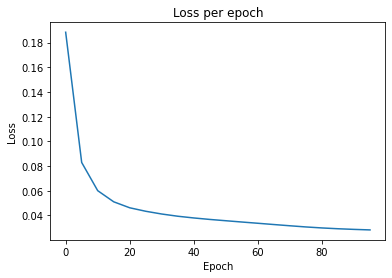

In [8]:
plt.plot(data['epoch'], data['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')

Text(0.5, 1.0, 'AUC per epoch')

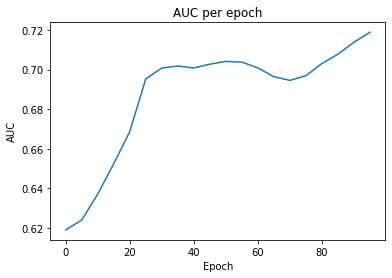

In [9]:
plt.plot(data['epoch'], data['auc'], label='auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC per epoch')

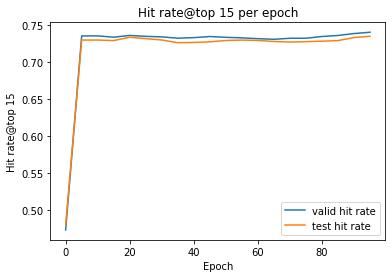

In [10]:
plt.plot(data['epoch'], data['valid hit rate'], label='valid hit rate')
plt.plot(data['epoch'], data['test hit rate'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 15')
plt.title('Hit rate@top 15 per epoch')
plt.legend()

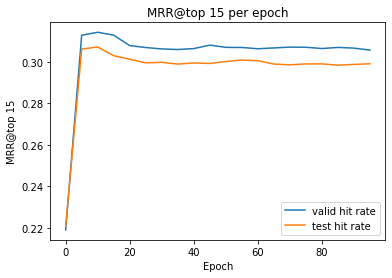

In [17]:
plt.plot(data['epoch'], data['valid MRR'], label='valid hit rate')
plt.plot(data['epoch'], data['test MRR'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('MRR@top 15')
plt.title('MRR@top 15 per epoch')
plt.legend()

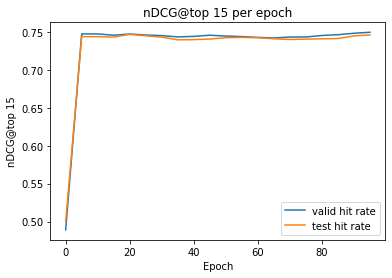

In [19]:
plt.plot(data['epoch'], data['valid nDCG'], label='valid hit rate')
plt.plot(data['epoch'], data['test nDCG'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('nDCG@top 15')
plt.title('nDCG@top 15 per epoch')
plt.legend()

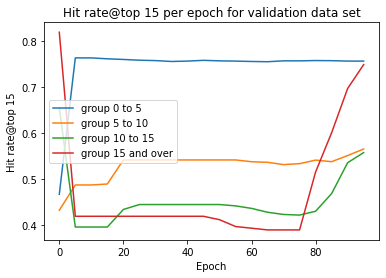

In [11]:
plt.plot(data['epoch'], data['hit rate valid group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['hit rate valid group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['hit rate valid group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['hit rate valid group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 15')
plt.title('Hit rate@top 15 per epoch for validation data set')
plt.legend()

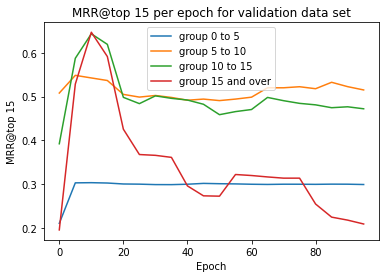

In [12]:
plt.plot(data['epoch'], data['MRR valid group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['MRR valid group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['MRR valid group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['MRR valid group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('MRR@top 15')
plt.title('MRR@top 15 per epoch for validation data set')
plt.legend()

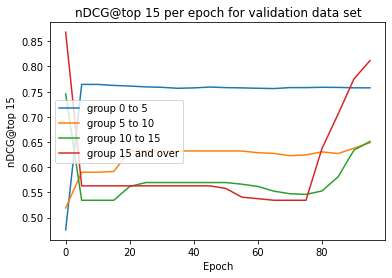

In [13]:
plt.plot(data['epoch'], data['nDCG valid group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['nDCG valid group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['nDCG valid group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['nDCG valid group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('nDCG@top 15')
plt.title('nDCG@top 15 per epoch for validation data set')
plt.legend()

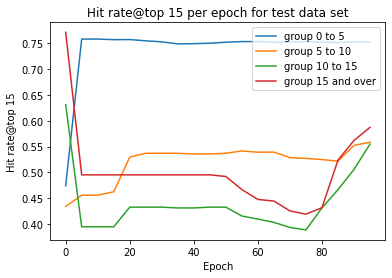

In [14]:
plt.plot(data['epoch'], data['hit rate test group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['hit rate test group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['hit rate test group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['hit rate test group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 15')
plt.title('Hit rate@top 15 per epoch for test data set')
plt.legend()

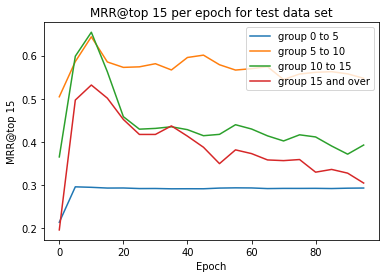

In [15]:
plt.plot(data['epoch'], data['MRR test group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['MRR test group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['MRR test group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['MRR test group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('MRR@top 15')
plt.title('MRR@top 15 per epoch for test data set')
plt.legend()

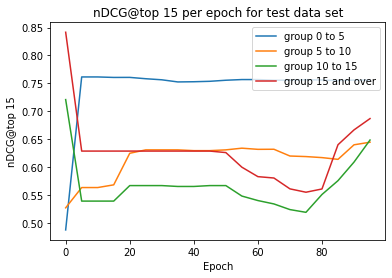

In [16]:
plt.plot(data['epoch'], data['nDCG test group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['nDCG test group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['nDCG test group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['nDCG test group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('nDCG@top 15')
plt.title('nDCG@top 15 per epoch for test data set')
plt.legend()

In [9]:
data['hit rate test group 1']

0     0.902985
1     0.208955
2     0.208955
3     0.208955
4     0.208955
5     0.208955
6     0.208955
7     0.208955
8     0.208955
9     0.208955
10    0.208955
11    0.208955
12    0.208955
13    0.208955
14    0.208955
15    0.208955
16    0.208955
17    0.208955
18    0.208955
19    0.208955
Name: hit rate test group 1, dtype: float64